- Code comparing timecourses of two movies with similar median RTs (coax/bill) or the same movie (rand). Specifically, we:
    - identify the earliest point of divergence in each ROI, and what kind of a difference it was - activation or deactivation

In parts 3 of this (separate notebook), we:    
- identify where the difference observed at the median RT (~TR=5) emerged
- identify the magnitude of difference pre and post the median RT

TO DO: EDIT CODE TO REMOVE FIXATION PTS FROM THE FMRI DATA BEFORE COMPARING TIMECOURSES 


Rekha Varrier - 2021

In [1]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [3]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'



In [4]:
# vid names as saved in behavioral data

vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]


In [5]:
#loading shen atlas labels

pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))

shen268.head()

# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

1  \
0  {'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}   

                                                                                                                                            2  \
0  {'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}   

                                                                                                                                          3  \
0  {'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}   

                                                                                                                                        4  \
0  {'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}   

                                                                                                                                                                                                            5  \
0  {'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}   

                                                                                                        6  \
0  {'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}   

                                                                                                         7  \
0  {'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}   

                                                                                                         8  \
0  {'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}   

                                                                                                         9  \
0  {'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}   

                                                                                                                                                     10  \
0  {'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}   

   ...  \
0  ...   

                                                                                                                                                                                                                              259  \
0  {'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}   

                                                                                                                                                            260  \
0  {'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}   

                                                                                                        261  \
0  {'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}   

                                                                                                                                             262  \
0  {'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}   

                                                                 

In [6]:
# load responses (nsubs * nmovies, values 0 for "no", 1 for "yes", "9" for unsure )
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses[0,:]

array([nan,  0.,  1., nan, nan,  1.,  1.,  0.,  1.,  9.])

In [7]:
# load fmri data

#### 1. SAME MOVIE/DIFFERENT SUBJECTS ANALYSIS. run-wise normalized data, so we restore amplitude differences

print('run-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy')
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('dims:',tcs_run_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_maxminnorm.npy')
tcs_run_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_same = 4 # CHANGE MOVIE INDEX HERE - FOR WITHIN-MOVIE ANALYSES
print('movie: ' + str(vidnames[movie_ind_same]))
subs1 = np.where(responses[:,movie_ind_same] == 1)[0]
subs2 = np.where(responses[:,movie_ind_same] == 0)[0] 
print('nr of subs for movie:' + str(movie_ind_same) + '. Yes responders' + str(subs1.shape) + ',No responders' + str(subs2.shape))

# same movie, old version with 14 extra TRs
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm_extra14TRs.npy')
tcs14_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


run-wise norm data.
dims: (1048, 268, 32, 10)
movie: Random mechanical
nr of subs for movie:4. Yes responders(88,),No responders(587,)


In [8]:
#### 2. DIFFERENT MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_z.shape)

fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_maxminnorm.npy')
tcs_trial_maxmin = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies


movie_ind_yes = 0 # CHANGE MOVIE IND HERE - SOCIAL
movie_ind_no = 1 # CHANGE MOVIE IND HERE - NONSOCIAL
print('"social" movie: ' + str(vidnames[movie_ind_yes]))
print('"nonsocial" movie: ' + str(vidnames[movie_ind_no]))

subs = np.where((responses[:,movie_ind_yes] == 1)&(responses[:,movie_ind_no] == 0))[0] 
print('nr of subs with yes for movie ' + str(movie_ind_yes) + ' and no for movie ' + str(movie_ind_no) + ' =' + str(subs.shape))

tcs_trial_z = tcs_trial_z[subs,:,:,:]
tcs_trial_maxmin = tcs_trial_maxmin[subs,:,:,:]
print('after:',tcs_trial_z.shape)



trial-wise norm data.
before: (1048, 268, 32, 10)
"social" movie: COAXING-B
"nonsocial" movie: BILLIARD-A
nr of subs with yes for movie 0 and no for movie 1 =(870,)
after: (870, 268, 32, 10)


to illustrate indiv data points, plotted in fig 1 are 5 exemplar subjects and the mean of ALL the subs


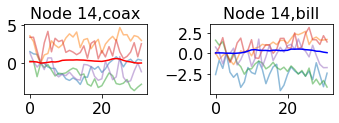

In [9]:
# plot trialwise norm timecourses
node_inds = [14]# change node inds here

print('to illustrate indiv data points, plotted in fig 1 are 5 exemplar subjects and the mean of ALL the subs')
plt.figure(1,figsize = (5,2))
plt.subplot(1,2,1)
plt.title(f'Node {node_inds[0]},coax')
plt.plot(tcs_trial_z[:5,node_inds[0],:,movie_ind_yes].T, alpha = 0.5)
plt.plot(np.nanmean(tcs_trial_z[:,node_inds[0],:,movie_ind_yes],axis=0), alpha = 1, color = 'red')
#plt.ylim(-1.5,1.5)

plt.subplot(1,2,2)
plt.title(f'Node {node_inds[0]},bill')
plt.plot(tcs_trial_z[:5,node_inds[0],:,movie_ind_no].T, alpha = 0.5)
plt.plot(np.nanmean(tcs_trial_z[:,node_inds[0],:,movie_ind_no],axis=0), alpha = 1, color = 'blue')
#plt.ylim(-1.5,1.5)

plt.tight_layout()

In [10]:
#### PAN-MOVIES ANALYSIS
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')
tcs_trial_all_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes = []
tcs_trial_resh_no = []


for m in range(10):
    tcs_trial_resh_yes.append(tcs_trial_all_z[responses[:,m]==1,:,:,m])# subsm * 268 * 32
    tcs_trial_resh_no.append(tcs_trial_all_z[responses[:,m]==0,:,:,m])# subsm * 268 * 32

tcs_trial_resh_yes = np.concatenate(tcs_trial_resh_yes,axis=0)
tcs_trial_resh_no = np.concatenate(tcs_trial_resh_no,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes.shape) + ',no:' + str(tcs_trial_resh_no.shape))


trial-wise norm data.
before: (1048, 268, 32, 10)
Across movies: 
	yes:(4905, 268, 32),no:(4294, 268, 32)


In [11]:
pop_responses = [1,0,0,1,0,1,1,0,1,0]
subsList = []
for s in range(responses.shape[0]):
    if list(responses[s,:]) == pop_responses:
        subsList.append(s)
print('num subs showing pop responses:', len(subsList))

num subs showing pop responses: 348


In [12]:
#### PAN-MOVIES ANALYSIS MATCHED
#select subs who responded "social" to the yes movie and nonsocial to the no movie

print('\ntrial-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_trial_norm','timecourse-all-movies_zscorenorm.npy')

print('before:',tcs_trial_all_z.shape)

tcs_trial_resh_yes_matched = []
tcs_trial_resh_no_matched = []


for m in range(10):
    if pop_responses[m] == 1:
        tcs_trial_resh_yes_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32
    elif pop_responses[m] == 0:
        tcs_trial_resh_no_matched.append(tcs_trial_all_z[subsList,:,:,m])# subsList * 268 * 32

tcs_trial_resh_yes_matched = np.concatenate(tcs_trial_resh_yes_matched,axis=0)
tcs_trial_resh_no_matched  = np.concatenate(tcs_trial_resh_no_matched,axis=0)
print('Across movies: \n\tyes:'+ str(tcs_trial_resh_yes_matched.shape) + ',no:' + str(tcs_trial_resh_no_matched.shape))

## caution: this is still not fully matched - just that both groups have the same subjects so we know the variance is shared.
#  Each subject is repeated within a group too.
# to do: is there a better way to do this? guess this can be compared to the block analysis of multiple stimuli


trial-wise norm data.
before: (1048, 268, 32, 10)
Across movies: 
	yes:(1740, 268, 32),no:(1740, 268, 32)


In [13]:
tr0_ind = 3 # ind at which tr=0 starts


In [14]:
# import module consisting of ttests to compare timecourses
from importlib import reload  
import ttests_movie_tcs as tmt # contains  ttest_diffmovies, ttest_samemovies
reload(tmt) # reload if the module/.py file is changed


<module 'ttests_movie_tcs' from '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code/on GitHub/exploration_earliest_timecourses_divergence_types/ttests_movie_tcs.py'>

0.92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex
1.58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex
no diff
no diff
no diff
2.47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole


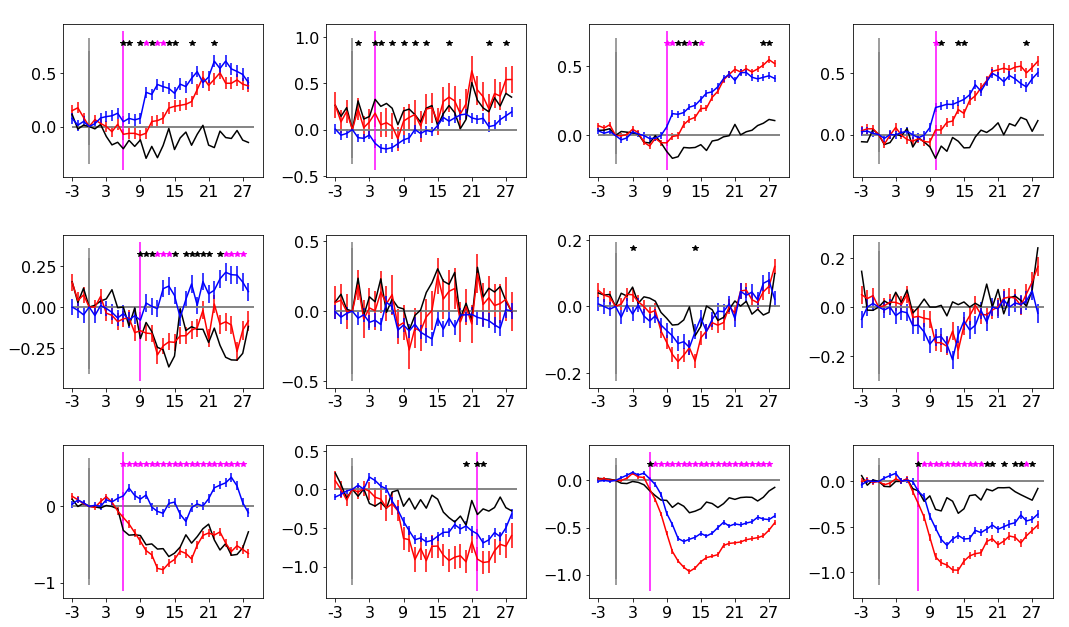

In [14]:
# test functions in the above modules

node_inds = [0,2,4]# change node inds here

plot_fig = 1
if plot_fig:
    plt.figure(1,figsize = (15,3*len(node_inds)))

for ind,node_ind in enumerate(node_inds):
    #node_ind = 14

    print(str(ind) + '.' + eval(shen268[str(node_ind+1)][0])['name'])

    plot_fig = 1
    if plot_fig:
        plt.subplot(len(node_inds),4,(ind*4+1))

    t_array = tmt.ttest_diffmovies(tcs_trial_z[:,node_ind,:,movie_ind_yes],
                                   tcs_trial_z[:,node_ind,:,movie_ind_no],
                                   plot_fig,'both',0,tr0_ind) # returns list of 2 arrays: indices with p<.05 and sign of yes-no difference
                                   # plot yes/no timecourses
    t_array = tmt.ttest_diffmovies(tcs_trial_z[:,node_ind,:,movie_ind_yes], 
                                   tcs_trial_z[:,node_ind,:,movie_ind_no],
                                   plot_fig,'diff',0,tr0_ind) # plot difference
    #print(t_array)
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1: #first index which is also followed by a significantly divergent timept
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    #print(ear)
    
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind},diff movies', color = 'w')


    # test above function same movie

    if plot_fig:
         plt.subplot(len(node_inds),4,(ind*4+2))
         
    t_array = tmt.ttest_samemovies(tcs_run_z[subs1,node_ind,:,movie_ind_same], 
                               tcs_run_z[subs2,node_ind,:,movie_ind_same],
                                   plot_fig,'both',0,tr0_ind) # plot yes/no timecourses
    t_array = tmt.ttest_samemovies(tcs_run_z[subs1,node_ind,:,movie_ind_same], 
                               tcs_run_z[subs2,node_ind,:,movie_ind_same],
                                   plot_fig,'diff',0,tr0_ind) # plot difference
    #print(t_array)
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    # print(ear)
    
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind},same movie', color = 'w')

    # test above function across all movies

    if plot_fig:
         plt.subplot(len(node_inds),4,(ind*4+3))
         
    
    t_array = tmt.ttest_samemovies(tcs_trial_resh_yes[:,node_ind,:], 
                               tcs_trial_resh_no[:,node_ind,:],
                                   plot_fig,'both',0,tr0_ind) # plot yes/no timecourses
    t_array = tmt.ttest_samemovies(tcs_trial_resh_yes[:,node_ind,:], 
                               tcs_trial_resh_no[:,node_ind,:],
                                   plot_fig,'diff',0,tr0_ind) # plot difference
    #TO DO: HAVE TO CONSIDER SHARE VARIANCE FOR A FORMAL ANALYSIS
    # THERE'S SOME SHARED VARIANCE, BUT THE GROUPS ARE NEITHER FULLY INDEPENDENT NOR FULLY DEPENDENT
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    # print(ear)
    
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind}, all movies', color = 'w')

    if plot_fig:
         plt.subplot(len(node_inds),4,(ind*4+4))
         
    t_array = tmt.ttest_diffmovies(tcs_trial_resh_yes_matched[:,node_ind,:], 
                               tcs_trial_resh_no_matched[:,node_ind,:],
                                   plot_fig,'both',0,tr0_ind) # plot yes/no timecourses
    t_array = tmt.ttest_diffmovies(tcs_trial_resh_yes_matched[:,node_ind,:], 
                               tcs_trial_resh_no_matched[:,node_ind,:],
                                   plot_fig,'diff',0,tr0_ind) # plot difference
    #TO DO: HAVE TO CONSIDER SHARE VARIANCE FOR A FORMAL ANALYSIS
    # THERE'S SOME SHARED VARIANCE, BUT THE GROUPS ARE NEITHER FULLY INDEPENDENT NOR FULLY DEPENDENT
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    # print(ear)
    
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind}, all movies matched', color = 'w')

plt.tight_layout()



- the timrecourses themselves and peak separation don't look too similar between coax/bill (left), rand (second from left) and the all movies figures, but these ROIs were picked out randomly. Maybe the overall brainmap or meaningful ROIs will show some similarity..
- third and fourth columns (across all movies) - with and without sub-selecting same subjects give similar results, so prob taking all subjects is fine (i.e., third column is probably fine in spite of the mixed subject pool) - but neither suffice for a formal analysis without further thought..

## Plot all nodes, save timepts of divergences within and between movies

In [18]:
str.upper(vidnames[movie_ind_yes][:4])

'COAX'

DIFF MOVIES
node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
saved


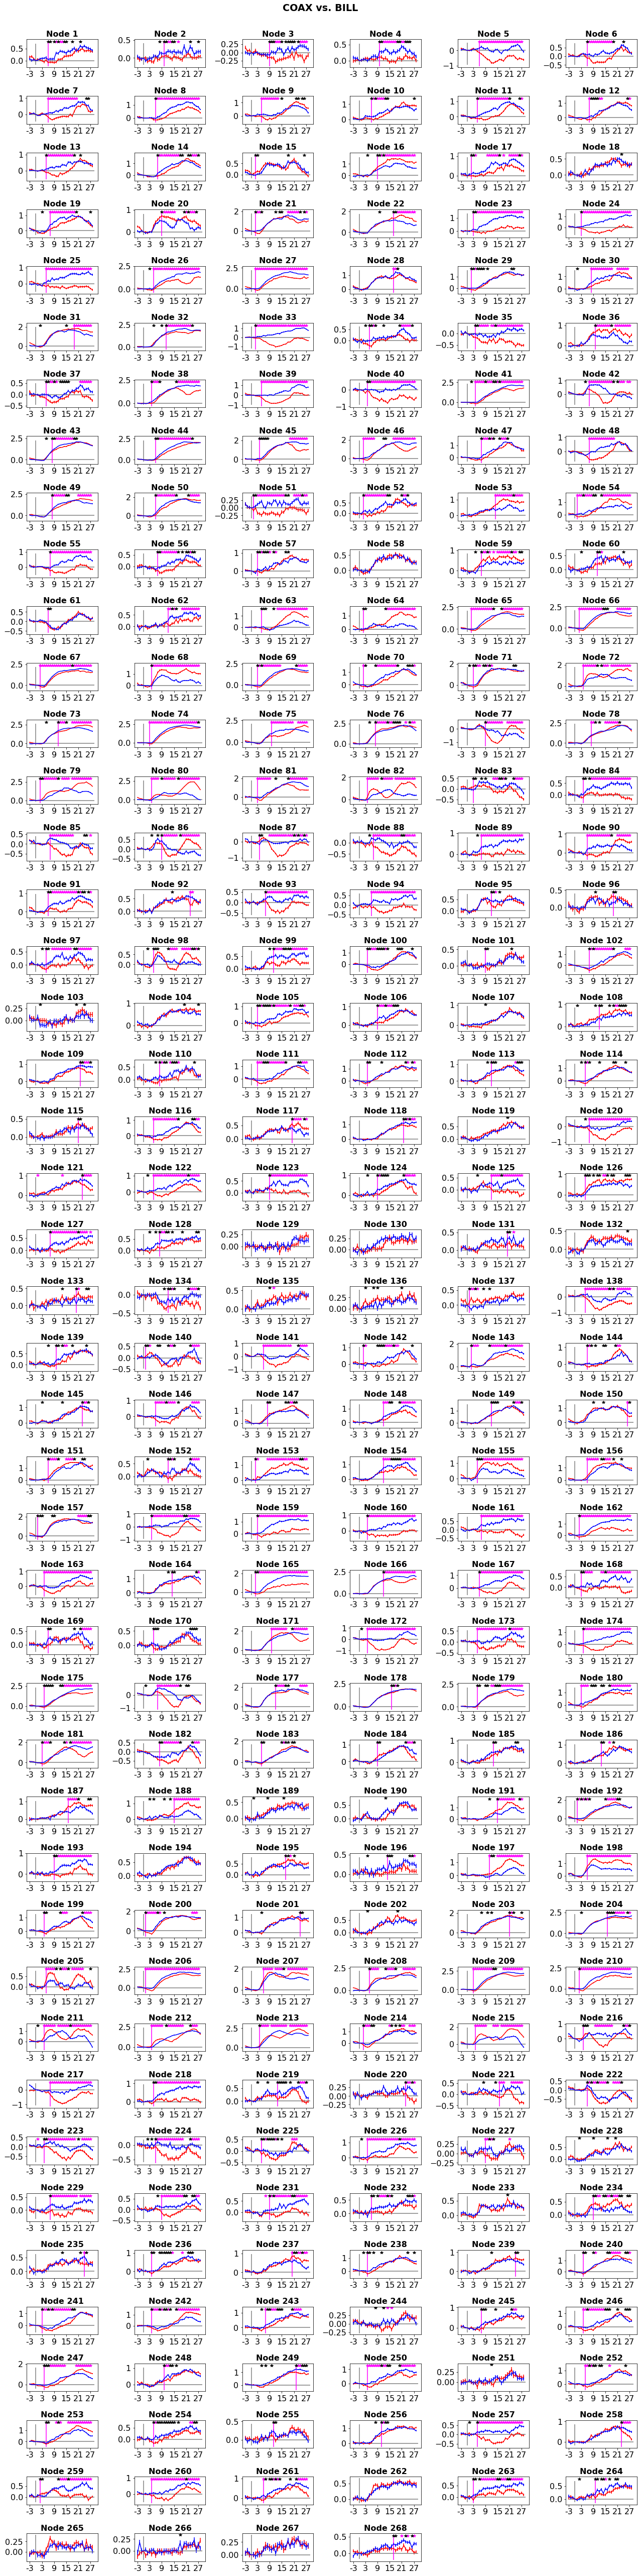

In [23]:
# plot of Yes vs. No timecourses and computing earliest timepoint at which difference first emerges
# Diff movies

import warnings
warnings.filterwarnings('ignore')

print('DIFF MOVIES')
earliest_pt_diff = np.empty((268,))
earliest_pt_diff[:] = np.nan
sign_earliest_pt_diff = np.empty_like(earliest_pt_diff)
sign_earliest_pt_diff[:] = np.nan

plot_fig = 1 # 1: PLOT FIGS, 0: DON'T PLOT

if plot_fig == 1:
    ncols=6
    nrows = 45
    #nrows = int(np.ceil(len(sig_nodes)/ncols))

    xwidth = 18
    yheight = .55*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)


nodes = np.arange(0,268)# np.arange(10)
ts = [] # 268 elements
for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_trial_z[:,n,:,movie_ind_yes] # nsubs * ntimepts
    movieTC_no = tcs_trial_z[:,n,:,movie_ind_no] # nsubs * ntimepts

    if plot_fig:
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.title('Node '+ str(n+1),fontweight = 'bold')

    t_array = tmt.ttest_diffmovies(movieTC_yes, movieTC_no,plot_fig,'both',0,tr0_ind) # returns sig timepts and their sign.
    # timept values in [0,28]
    ts.append(t_array)
    #print(t_array)
    
    #earliest_pt[n] = t_array[0][0] if len(t_array[0])>0 else np.nan
    # first ind of the 1st list element (second is sign)
    #sign_earliest_pt[n] = t_array[1][0] if len(t_array[0])>0 else np.nan

    
    if len(t_array[0])> 1:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                earliest_pt_diff[n]      = t_array[0][i]
                sign_earliest_pt_diff[n] = t_array[1][i]
                break
                if abs(earliest_pt_diff[n]) > 27:
                    print(t_array,t_array[0][i])

    if plot_fig:
        ymin,ymax = plt.ylim()
        plt.vlines(earliest_pt_diff[n]+tr0_ind,ymin,ymax,color = 'magenta')
    
if plot_fig:
    for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.axis('off')

    plt.suptitle('COAX vs. BILL',fontweight='bold')

    fig.tight_layout(rect=[0, 0.02, 1, 0.98])
    moviename = f'timecourses_Yes_vs_No_movie{str.upper(vidnames[movie_ind_yes][:4])}_movie{str.upper(vidnames[movie_ind_no][:4])}.png'
    plt.savefig(os.path.join(data_file_loc,'figures','timecourses',moviename))

np.save(os.path.join(data_file_loc,'earliest_pt_div_diffmovies.npy'), ts)
print('saved')


SAME MOVIE
node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
saved


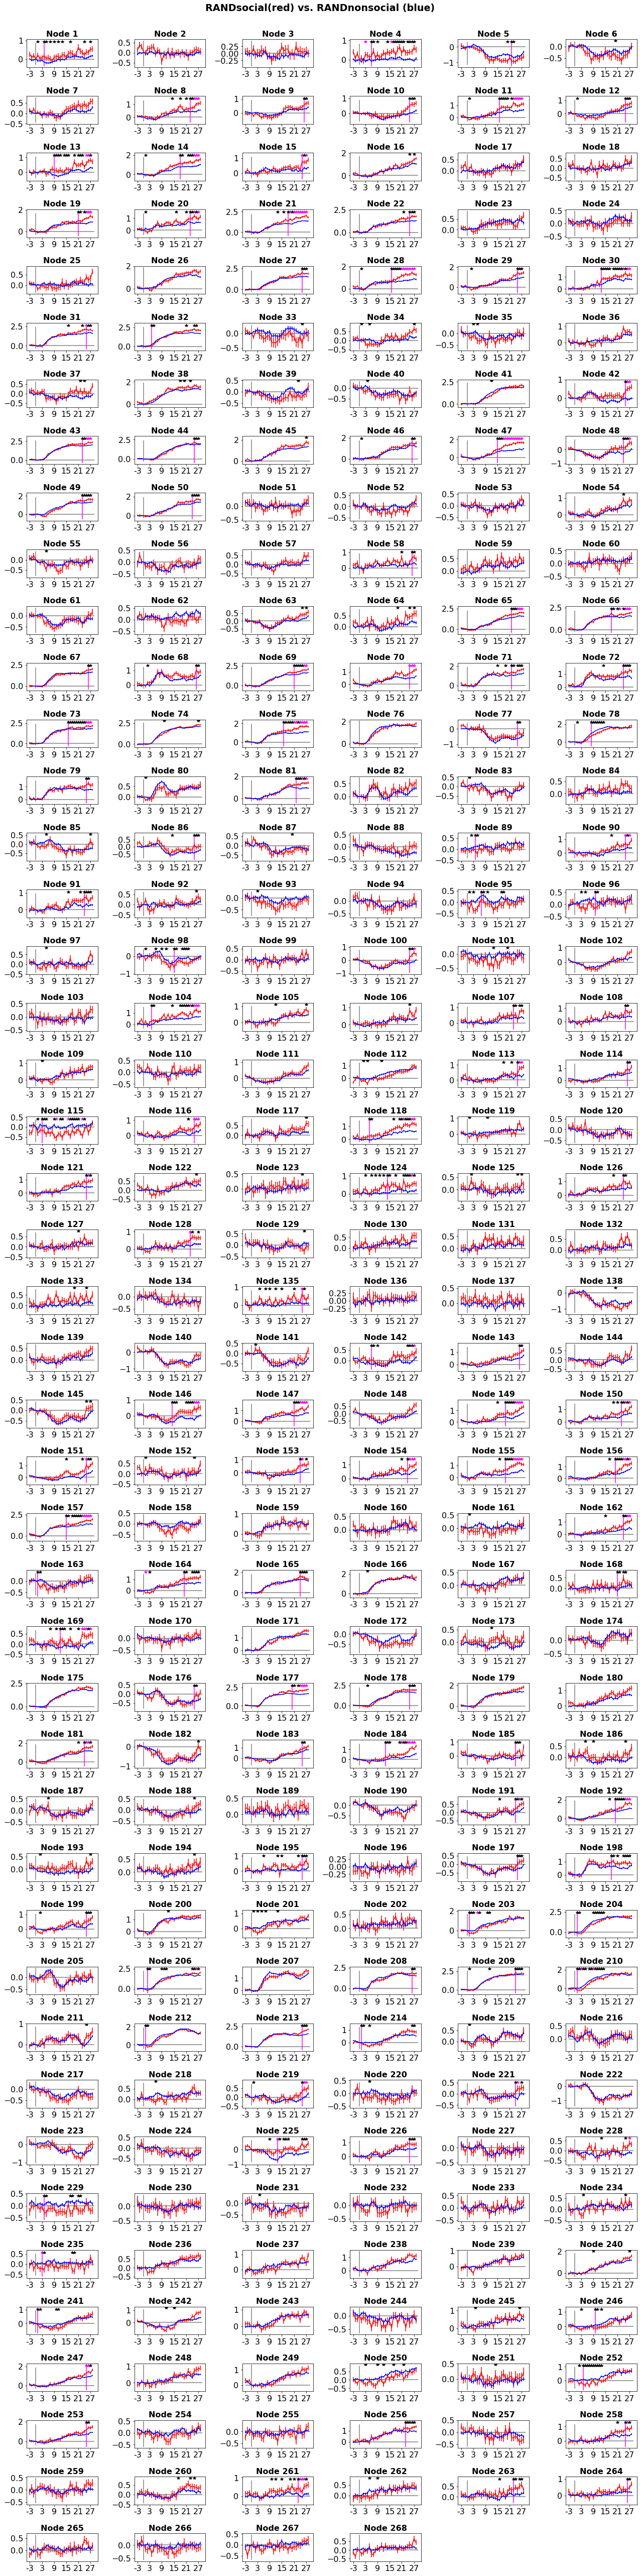

In [22]:
# plot of Yes vs. No timecourses and computing earliest timepoint at which difference first emerges
# Same movie

import warnings
warnings.filterwarnings('ignore')
    
print('SAME MOVIE')
earliest_pt_same = np.empty((268,))
earliest_pt_same[:] = np.nan
sign_earliest_pt_same = np.empty_like(earliest_pt_same)
sign_earliest_pt_same[:] = np.nan

plot_fig = 1 # 1: PLOT FIGS, 0: DON'T PLOT

if plot_fig == 1:
    ncols=6
    nrows = 45
    #nrows = int(np.ceil(len(sig_nodes)/ncols))

    xwidth = 18
    yheight = .55*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)


nodes = np.arange(0,268)# np.arange(10)
ts = [] # 268 elements
for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_run_z[subs1,n,:,movie_ind_same] # nsubs * ntimepts
    movieTC_no = tcs_run_z[subs2,n,:,movie_ind_same] # nsubs * ntimepts

    if plot_fig:
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.title('Node '+ str(n+1),fontweight = 'bold')

    t_array = tmt.ttest_samemovies(movieTC_yes, movieTC_no,plot_fig,'both',
                                  0,tr0_ind) # returns sig timepts and their sign.
    # timept values in [0,28]
    ts.append(t_array)
    #print(t_array)
    
    
    if len(t_array[0])> 1:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                earliest_pt_same[n]      = t_array[0][i]
                sign_earliest_pt_same[n] = t_array[1][i]
                break
                if abs(earliest_pt_same[n]) > 27:
                    print(t_array,t_array[0][i])

    if plot_fig:
        ymin,ymax = plt.ylim()
        plt.vlines(earliest_pt_same[n]+tr0_ind,ymin,ymax,color = 'magenta')
    
if plot_fig:
    for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.axis('off')

    plt.suptitle('RANDsocial(red) vs. RANDnonsocial (blue)',fontweight='bold')

    fig.tight_layout(rect=[0, 0.02, 1, 0.98])
    moviename = f'timecourses_Yes_vs_No_movie{str.upper(vidnames[movie_ind_same][:4])}_movie{str.upper(vidnames[movie_ind_same][:4])}.png'
    plt.savefig(os.path.join(data_file_loc,'figures','timecourses',moviename))

np.save(os.path.join(data_file_loc,'earliest_pt_div_samemovie.npy'), ts)
print('saved')


all MOVIES
node: 0
node: 50
node: 100
node: 150
node: 200
node: 250
saved


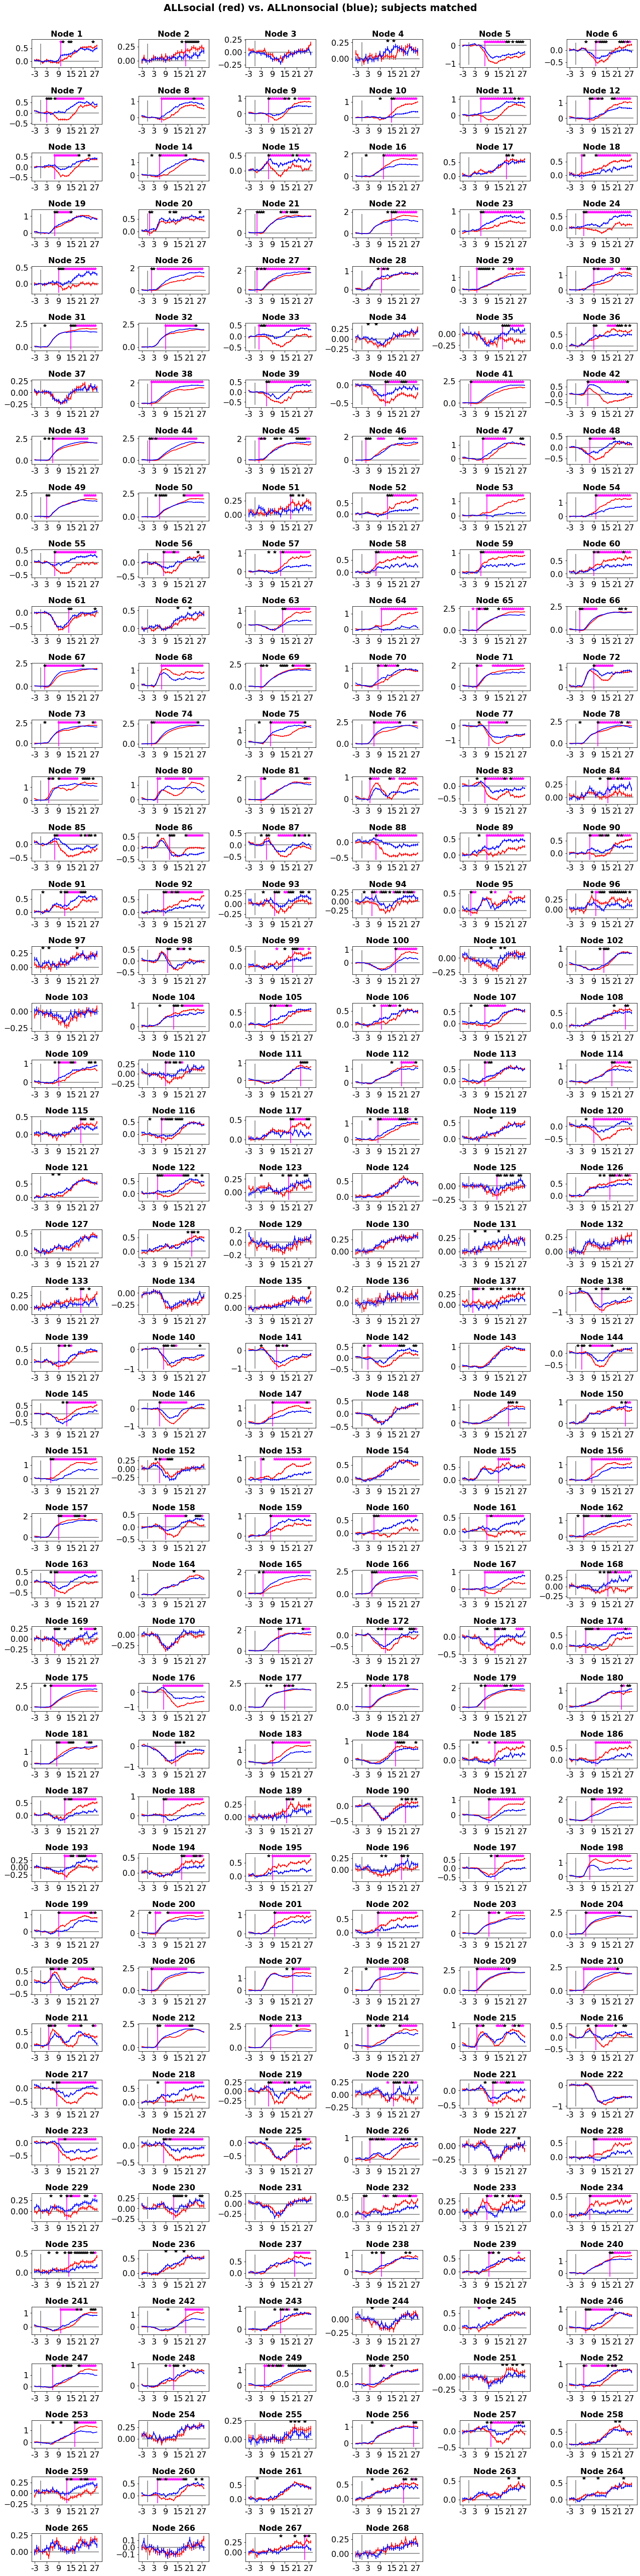

In [24]:
# plot of Yes vs. No timecourses and computing earliest timepoint at which difference first emerges
# all movies

import warnings
warnings.filterwarnings('ignore')
    
print('all MOVIES')
earliest_pt_all = np.empty((268,))
earliest_pt_all[:] = np.nan
sign_earliest_pt_all = np.empty_like(earliest_pt_all)
sign_earliest_pt_all[:] = np.nan

plot_fig = 1 # 1: PLOT FIGS, 0: DON'T PLOT

if plot_fig == 1:
    ncols=6
    nrows = 45
    #nrows = int(np.ceil(len(sig_nodes)/ncols))

    xwidth = 18
    yheight = .55*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)


nodes = np.arange(0,268)# np.arange(10)
ts = [] # 268 elements
for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_trial_resh_yes_matched[:,n,:] # nsubs * ntimepts
    movieTC_no = tcs_trial_resh_no_matched[:,n,:] # nsubs * ntimepts

    if plot_fig:
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.title('Node '+ str(n+1),fontweight = 'bold')

    t_array = tmt.ttest_samemovies(movieTC_yes, movieTC_no,plot_fig,'both',
                                  0,tr0_ind) # returns sig timepts and their sign.
    # timept values in [0,28]
    ts.append(t_array)
    #print(t_array)
    
    
    if len(t_array[0])> 1:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                earliest_pt_all[n]      = t_array[0][i]
                sign_earliest_pt_all[n] = t_array[1][i]
                break
                if abs(earliest_pt_same[n]) > 27:
                    print(t_array,t_array[0][i])

    if plot_fig:
        ymin,ymax = plt.ylim()
        plt.vlines(earliest_pt_all[n]+tr0_ind,ymin,ymax,color = 'magenta')
    
if plot_fig:
    for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.axis('off')

    plt.suptitle('ALLsocial (red) vs. ALLnonsocial (blue); subjects matched',fontweight='bold')

    fig.tight_layout(rect=[0, 0.02, 1, 0.98])
    moviename = f'timecourses_Yes_vs_No_allmovies.png'
    plt.savefig(os.path.join(data_file_loc,'figures','timecourses',moviename))

np.save(os.path.join(data_file_loc,'earliest_pt_div_allmovies.npy'), ts)
print('saved')


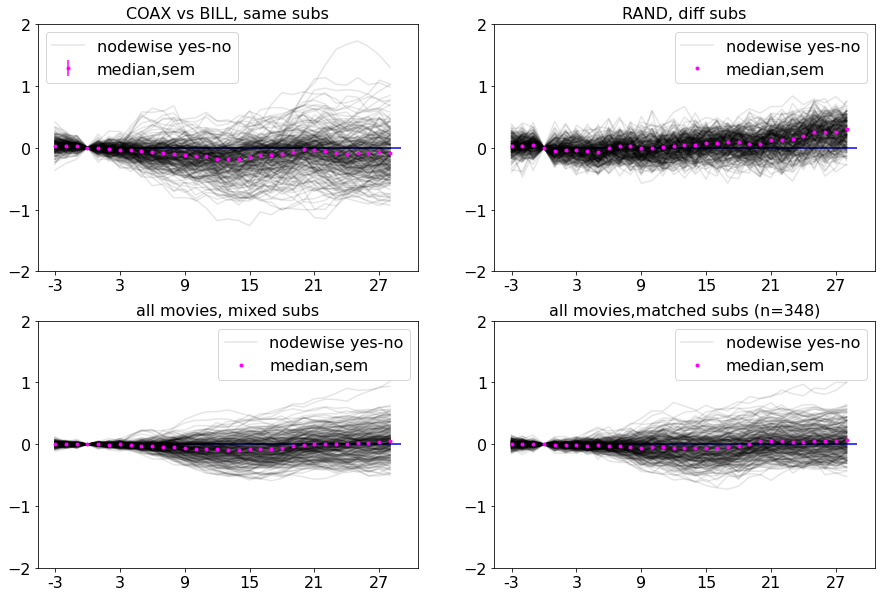

In [23]:
# Visualize all social-random differences in a single plot

#all MOVIES
plot_fig =1
plt.figure(1,figsize = (15,10))
nodes = np.arange(0,268)# np.arange(10)
plt.subplot(2,2,1)
# plot indiv diffs for each node in black
for i_nodes,n in enumerate(nodes):
    movieTC_yes = tcs_trial_z[:,n,:,movie_ind_yes] # nsubs * ntimepts
    movieTC_no = tcs_trial_z[:,n,:,movie_ind_no] # nsubs * ntimepts
    if i_nodes ==0:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes-movieTC_no,axis=0),
                 color = 'k', alpha = .1, label = 'nodewise yes-no')
    else:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes-movieTC_no,axis=0),
                 color = 'k', alpha = .1)
    #t_array = tmt.ttest_diffmovies(movieTC_yes, movieTC_no,plot_fig, 'difference',1,tr0_ind) # values in [0,28]

plt.ylim(-2,2)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])

#plot mean difference in magenta
diff = tcs_trial_z[:,:,:,movie_ind_yes] - tcs_trial_z[:,:,:,movie_ind_no]  # nnodes*nsubs * ntimepts
diff = np.array([np.ndarray.flatten(diff[:,:,i]) for i in range(diff.shape[2])]).T # collapsing subs and nodes
plt.errorbar(np.arange(diff.shape[1]),np.nanmedian(diff,axis=0),
         stats.sem(diff,axis=0,nan_policy='omit'),marker = '.',
             ls = 'None',color = 'magenta', label = 'median,sem')
plt.hlines(0,0,32,color = 'b')
plt.title('COAX vs BILL, same subs')
plt.legend()

# SAME MOVIE
plt.subplot(2,2,2)
nodes = np.arange(0,268)# np.arange(10)
for i_nodes,n in enumerate(nodes):
    movieTC_yes = tcs_run_z[subs1,n,:,movie_ind_same] # nsubs * ntimepts
    movieTC_no = tcs_run_z[subs2,n,:,movie_ind_same] # nsubs * ntimepts
    if i_nodes ==0:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no,axis=0),
             color = 'k', alpha = .1, label = 'nodewise yes-no')
    else:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no,axis=0),
             color = 'k', alpha = .1)
    
    #t_array = tmt.ttest_samemovies(movieTC_yes, movieTC_no, plot_fig, 'difference',1,tr0_ind) # values in [0,28]

plt.ylim(-2,2)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])

diff = np.nanmedian(tcs_run_z[subs1,:,:,movie_ind_same],axis=(0,1)) - \
        np.nanmedian(tcs_run_z[subs2,:,:,movie_ind_same],axis=(0,1))
plt.plot(np.arange(diff.shape[0]),diff,  marker = '.',ls = 'None',color = 'magenta', label = 'median,sem')
plt.hlines(0,0,32,color = 'b')
plt.title('RAND, diff subs')
plt.legend()

# ALL MOVIES
plt.subplot(2,2,3)
nodes = np.arange(0,268)# np.arange(10)
for i_nodes,n in enumerate(nodes):
    movieTC_yes = tcs_trial_resh_yes[:,n,:] # nsubs * ntimepts
    movieTC_no = tcs_trial_resh_no[:,n,:] # nsubs * ntimepts
    if i_nodes ==0:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no,axis=0),
             color = 'k', alpha = .1, label = 'nodewise yes-no')
    else:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no, axis=0),
             color = 'k', alpha = .1)
    
    #t_array = tmt.ttest_samemovies(movieTC_yes, movieTC_no, plot_fig, 'difference',1,tr0_ind) # values in [0,28]

plt.ylim(-2,2)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])

diff = np.nanmedian(tcs_trial_resh_yes,axis=(0,1)) - np.nanmedian(tcs_trial_resh_no,axis=(0,1))
plt.plot(np.arange(diff.shape[0]),diff,  marker = '.',ls = 'None',color = 'magenta', label = 'median,sem')
plt.hlines(0,0,32,color = 'b')
plt.title('all movies, mixed subs')
plt.legend()

#ALL MOVIES, MATCHED
plt.subplot(2,2,4)
nodes = np.arange(0,268)# np.arange(10)
for i_nodes,n in enumerate(nodes):
    movieTC_yes = tcs_trial_resh_yes_matched[:,n,:] # nsubs * ntimepts
    movieTC_no = tcs_trial_resh_no_matched[:,n,:] # nsubs * ntimepts
    if i_nodes ==0:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no,axis=0),
             color = 'k', alpha = .1, label = 'nodewise yes-no')
    else:
        plt.plot(np.arange(movieTC_yes.shape[1]),np.nanmedian(movieTC_yes,axis=0)-np.nanmedian(movieTC_no,axis=0),
             color = 'k', alpha = .1)
    
    #t_array = tmt.ttest_samemovies(movieTC_yes, movieTC_no, plot_fig, 'difference',1,tr0_ind) # values in [0,28]

plt.ylim(-2,2)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])

diff = np.nanmedian(tcs_trial_resh_yes_matched,axis=(0,1)) - np.nanmedian(tcs_trial_resh_no_matched, axis=(0,1))
plt.plot(np.arange(diff.shape[0]),diff,  marker = '.',ls = 'None',color = 'magenta', label = 'median,sem')
plt.hlines(0,0,32,color = 'b')
plt.title('all movies,matched subs (n=348)')
plt.legend()


In [18]:
tcs_trial_resh_yes_matched.shape

(1740, 268, 32)

- In spite of the detrending, trialwise-normalization and baseline correction, the average activity tends to decrease from COAXING to BILLIARDS (upper left) (across nodes), but are above zero for RAND - this could be either a movie-wise difference or could be lesser variance since in the latter case it's a difference of means for each node whereas the former was the mean of the difference (because subjects were paired). ALso decision times were more comparable for coax/bill than within rand. 
- but comparing across all yes/no responses results in a mean closer to zero (lower figures)
- just a point to note, nothing much to do with this

Text(0.5, 1.0, 'Social(RAND)-Random(RAND)')

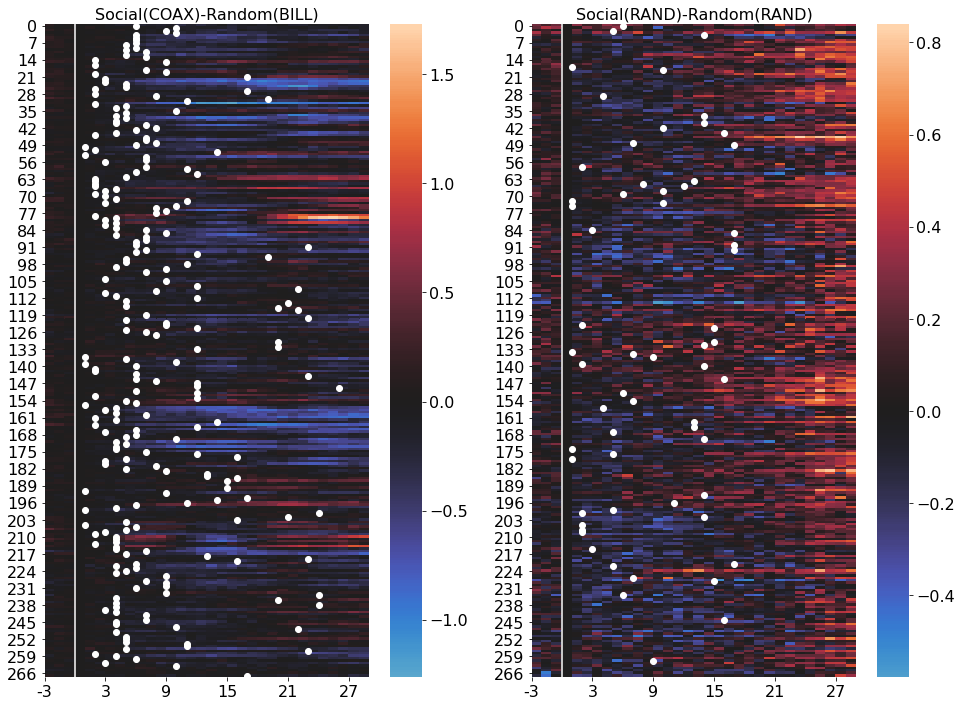

In [63]:
# visualizing earliest divergence points from the t-test
# coaxing - billiards
plt.figure(1,figsize = (16,12))
plt.subplot(1,2,1)
sns.heatmap(np.nanmedian(tcs_trial_z[:,:,:,movie_ind_yes] - tcs_trial_z[:,:,:,movie_ind_no],axis=0),center = 0)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])
plt.vlines(3,0,tcs_trial_z.shape[0],color = 'w')
plt.plot(earliest_pt_diff+tr0_ind,np.arange(268)+.5,color ='white', marker = 'o', ls = 'None')
plt.title('Social(COAX)-Random(BILL)')
#plt.ylim(0,2)

# randyes - randno
plt.subplot(1,2,2)
sns.heatmap(np.nanmedian(tcs_run_z[subs1,:,:,movie_ind_same],axis=0) - 
            np.nanmedian(tcs_run_z[subs2,:,:,movie_ind_same],axis=0),center = 0)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])
plt.vlines(3,0,tcs_trial_z.shape[0],color = 'w')
plt.plot(earliest_pt_same+tr0_ind,np.arange(268)+.5,color ='white', marker = 'o', ls = 'None')

plt.title('Social(RAND)-Random(RAND)')
#plt.ylim(0,2)

# TO DO: double-check the white dots



Text(0, 0.5, 'earliestpt,\nsamemovie diffsubs')

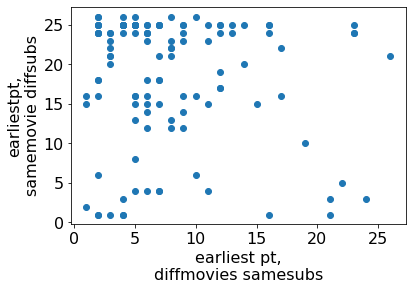

In [138]:
plt.scatter(earliest_pt_diff,earliest_pt_same)
plt.xlabel('earliest pt,\ndiffmovies samesubs')
plt.ylabel('earliestpt,\nsamemovie diffsubs')

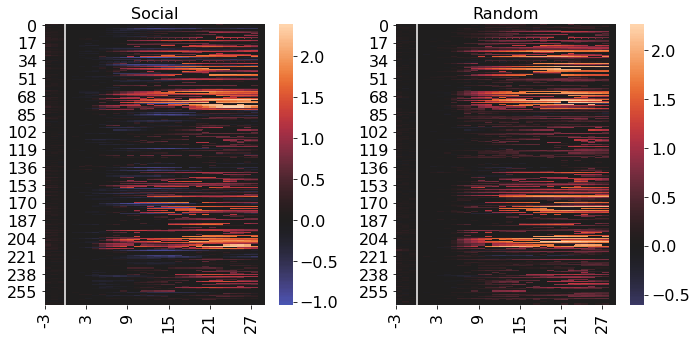

In [15]:
# coaxing, billiards separately

plt.figure(1,figsize = (10,5))
mean_diff_all = np.zeros((268,32))
for n in range(268):
    inds = ts[n][0]
    mean_diff_ = np.nanmedian(tc_all[:,n,:,movie_ind_yes],axis=0)
    for i in np.arange(3,len(mean_diff_)):
        if i-3 not in inds:
            mean_diff_[i] = 0
    mean_diff_all[n,:] = mean_diff_
plt.subplot(1,2,1)    
sns.heatmap(mean_diff_all,center = 0)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])
plt.vlines(3,0,tc_all.shape[0],color = 'w')
plt.title('Social')


mean_diff_all = np.zeros((268,32))
for n in range(268):
    inds = ts[n][0]
    mean_diff_ = np.nanmedian(tc_all[:,n,:,movie_ind_no],axis=0)
    for i in np.arange(3,len(mean_diff_)):
        if i-3 not in inds:
            mean_diff_[i] = 0
    mean_diff_all[n,:] = mean_diff_
plt.subplot(1,2,2)             
sns.heatmap(mean_diff_all,center = 0)
plt.xticks(np.arange(0,32,6),[str(i) for i in np.arange(0,32,6)-tr0_ind])
plt.vlines(3,0,tc_all.shape[0],color = 'w')
plt.title('Random')
plt.tight_layout()


# not plotting the heatmaps for the same movie for now - can do so if necessary later.

### Plot earliest point on a brainmap

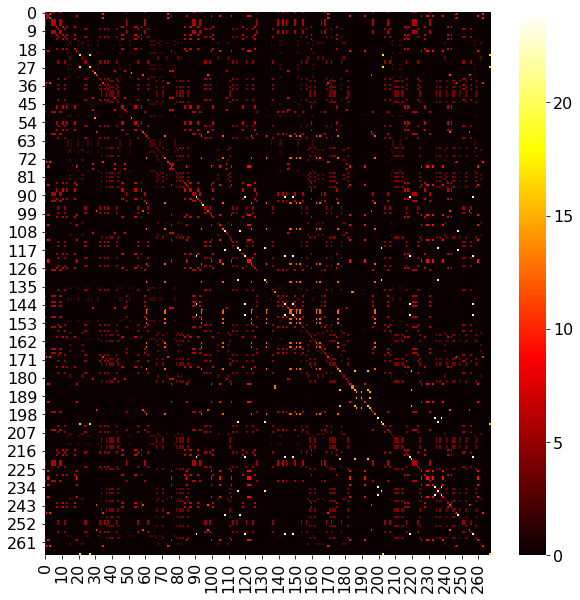

In [116]:
earliest_pt_map = np.empty((268,268))
earliest_pt_map[:] = np.nan
plt.figure(1,figsize = (10,10))
for n1 in range(268):
    earliest_pt_map[n1,:] = [earliest_pt_diff[n2] if earliest_pt_diff[n2] == earliest_pt_diff[n1] else 0 for n2 in range(268)]
sns.heatmap(earliest_pt_map, cmap = 'hot')

pd.DataFrame(earliest_pt_map).to_csv(os.path.join(data_file_loc,'earliest_pt_map.csv'),
                                     header=None, index=None)

# extra code

to illustrate indiv data points, plotted in fig 1 are 5 exeplar subjects and the mean of ALL the subs


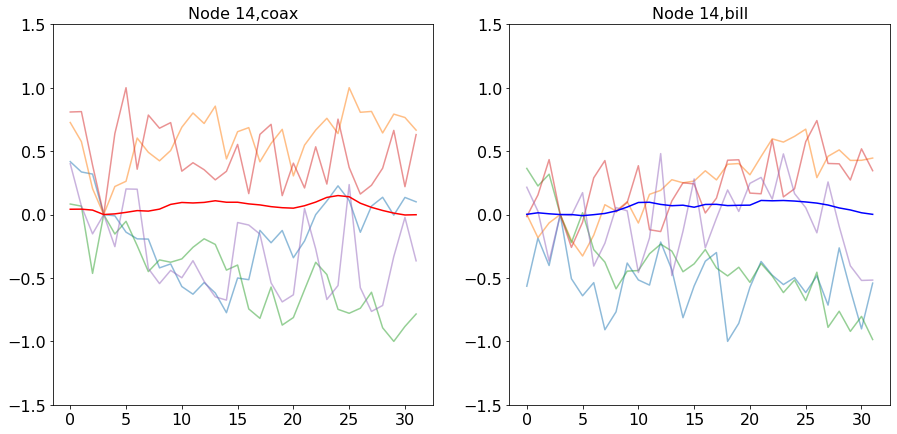

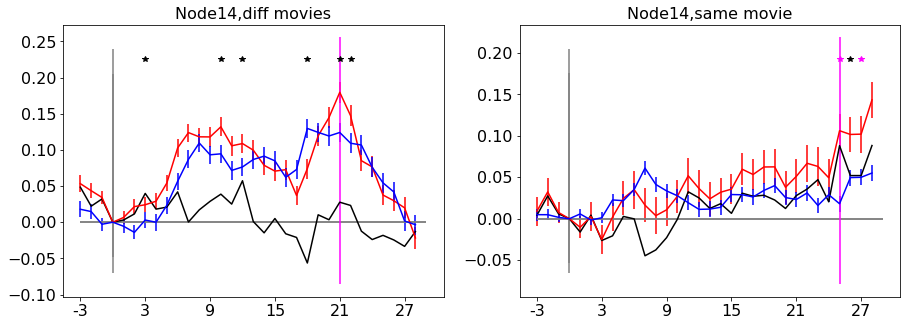

In [34]:
# test ttests function with MAXMIN normalized data


node_inds = [14]# change node inds here
print('to illustrate indiv data points, plotted in fig 1 are 5 exeplar subjects and the mean of ALL the subs')

plt.figure(1,figsize = (15,7))
plt.subplot(1,2,1)
plt.title(f'Node {node_inds[0]},coax')
plt.plot(tcs_trial_maxmin[:5,node_inds[0],:,movie_ind_yes].T, alpha = 0.5)
plt.plot(np.nanmean(tcs_trial_maxmin[:,node_inds[0],:,movie_ind_yes],axis=0), alpha = 1, color = 'red')
plt.ylim(-1.5,1.5)

plt.subplot(1,2,2)
plt.title(f'Node {node_inds[0]},bill')
plt.plot(tcs_trial_maxmin[:5,node_inds[0],:,movie_ind_no].T, alpha = 0.5)
plt.plot(np.nanmean(tcs_trial_maxmin[:,node_inds[0],:,movie_ind_no],axis=0), alpha = 1, color = 'blue')
plt.ylim(-1.5,1.5)


plot_fig = 1
if plot_fig:
    plt.figure(2,figsize = (15,5*len(node_inds)))

for ind,node_ind in enumerate(node_inds):
    #node_ind = 14

    plot_fig = 1
    if plot_fig:
        plt.subplot(len(node_inds),2,(ind*2+1))

    t_array = tmt.ttest_diffmovies(tcs_trial_maxmin[:,node_ind,:,movie_ind_yes], 
                               tcs_trial_maxmin[:,node_ind,:,movie_ind_no],
                                   plot_fig,'both',0,tr0_ind)
    t_array = tmt.ttest_diffmovies(tcs_trial_maxmin[:,node_ind,:,movie_ind_yes], 
                               tcs_trial_maxmin[:,node_ind,:,movie_ind_no],
                                   plot_fig,'diff',0,tr0_ind)
    #print(t_array)
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    #print(ear)
    
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind},diff movies')


    # test above function same movie

    if plot_fig:
         plt.subplot(len(node_inds),2,(ind*2+2))

    t_array = tmt.ttest_samemovies(tcs_run_maxmin[subs1,node_ind,:,movie_ind_same], 
                               tcs_run_maxmin[subs2,node_ind,:,movie_ind_same],
                                   plot_fig,'both',0,tr0_ind)
    t_array = tmt.ttest_samemovies(tcs_run_maxmin[subs1,node_ind,:,movie_ind_same], 
                               tcs_run_maxmin[subs2,node_ind,:,movie_ind_same],
                                   plot_fig,'diff',0,tr0_ind)
    #print(t_array)
    ear=[]
    if len(t_array)>0:
        for i in range(len(t_array[0])-1):
            if t_array[0][i+1] - t_array[0][i] == 1:
                ear = [t_array[0][i], t_array[1][i]]
                break
    else:
        ear = np.nan
    # print(ear)
    ymin,ymax = plt.ylim()
    try:
        plt.vlines(ear[0]+tr0_ind,ymin,ymax, color = 'magenta')
    except: 
        print('no diff')

    plt.title(f'Node{node_ind},same movie')




node: 0
node: 50
node: 100
node: 150
node: 200
node: 250


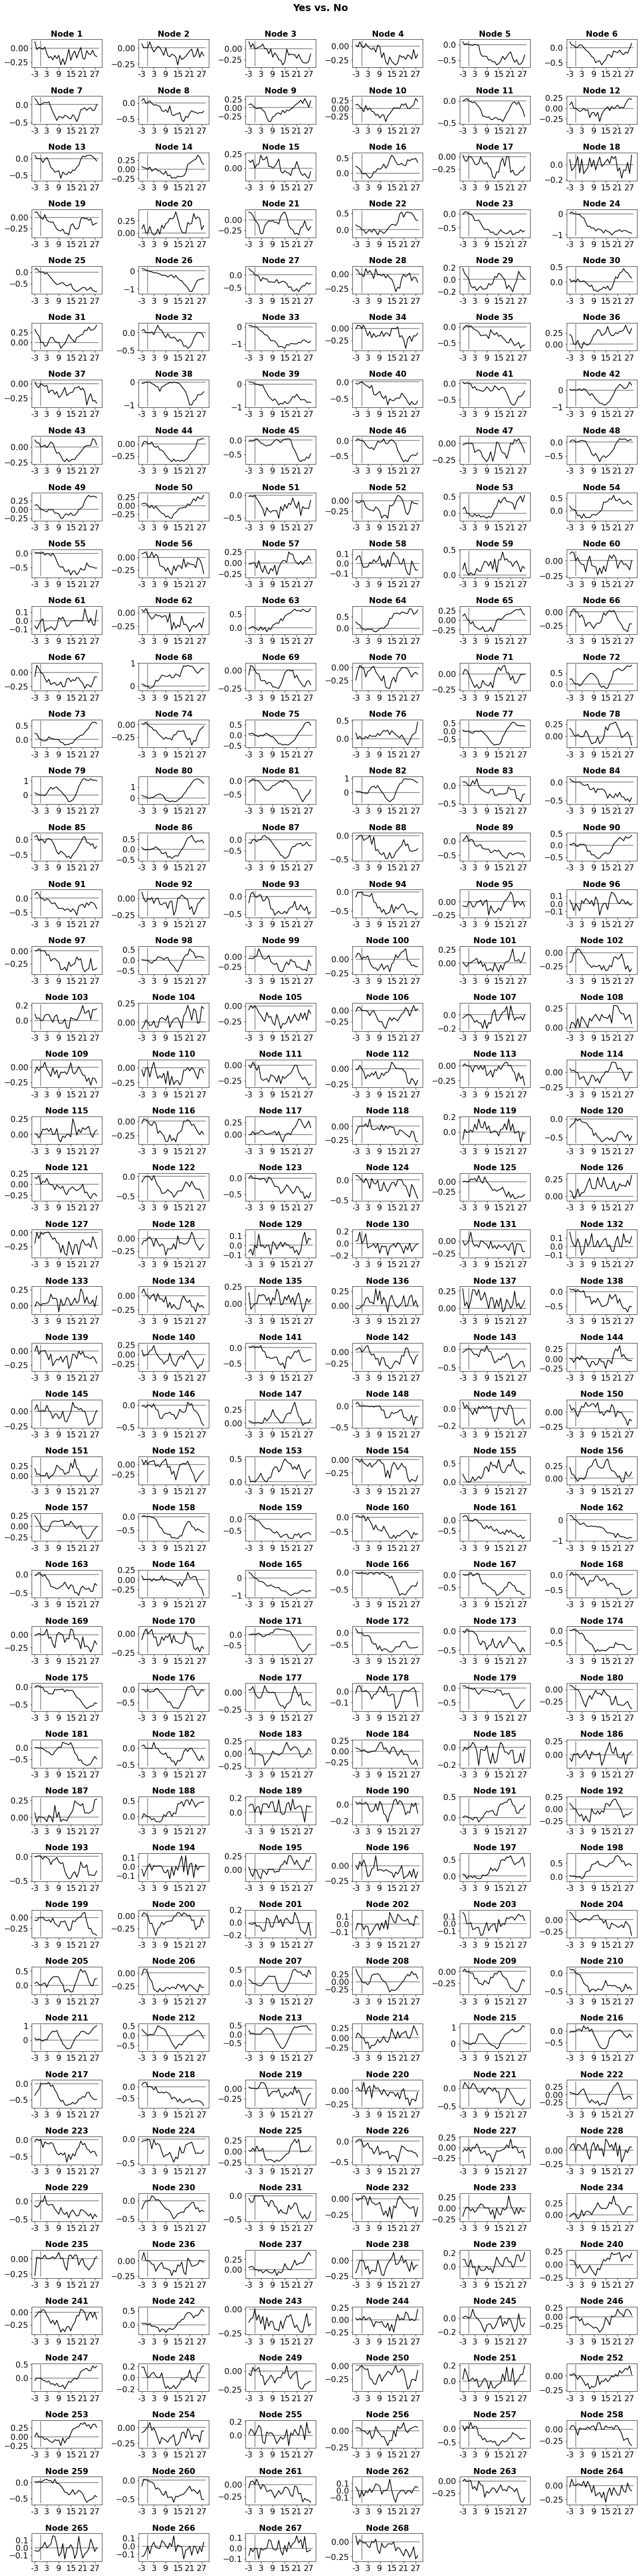

In [47]:
# social - nonsocial differences for each node
# diff movies

if plot_fig == 1:
    ncols=6
    nrows = 45
    #nrows = int(np.ceil(len(sig_nodes)/ncols))

    xwidth = 18
    yheight = .55*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)


nodes = np.arange(0,268)# np.arange(10)

for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_trial_z[:,n,:,movie_ind_yes] # nsubs * ntimepts
    movieTC_no = tcs_trial_z[:,n,:,movie_ind_no] # nsubs * ntimepts

    if plot_fig:
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.title('Node '+ str(n+1),fontweight = 'bold')

    t_array = tmt.ttest_diffmovies(movieTC_yes, movieTC_no, plot_fig, 'difference',tr0_ind) # values in [0,28]
    
if plot_fig:
    for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.axis('off')

    plt.suptitle('Yes vs. No',fontweight='bold')
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])
    moviename = f'timecourses_Yes_vs_No_movie{movie_ind_yes}_movie{movie_ind_no}.png'
    plt.savefig(os.path.join(data_file_loc,'figures',moviename))



node: 0
node: 50
node: 100
node: 150
node: 200
node: 250


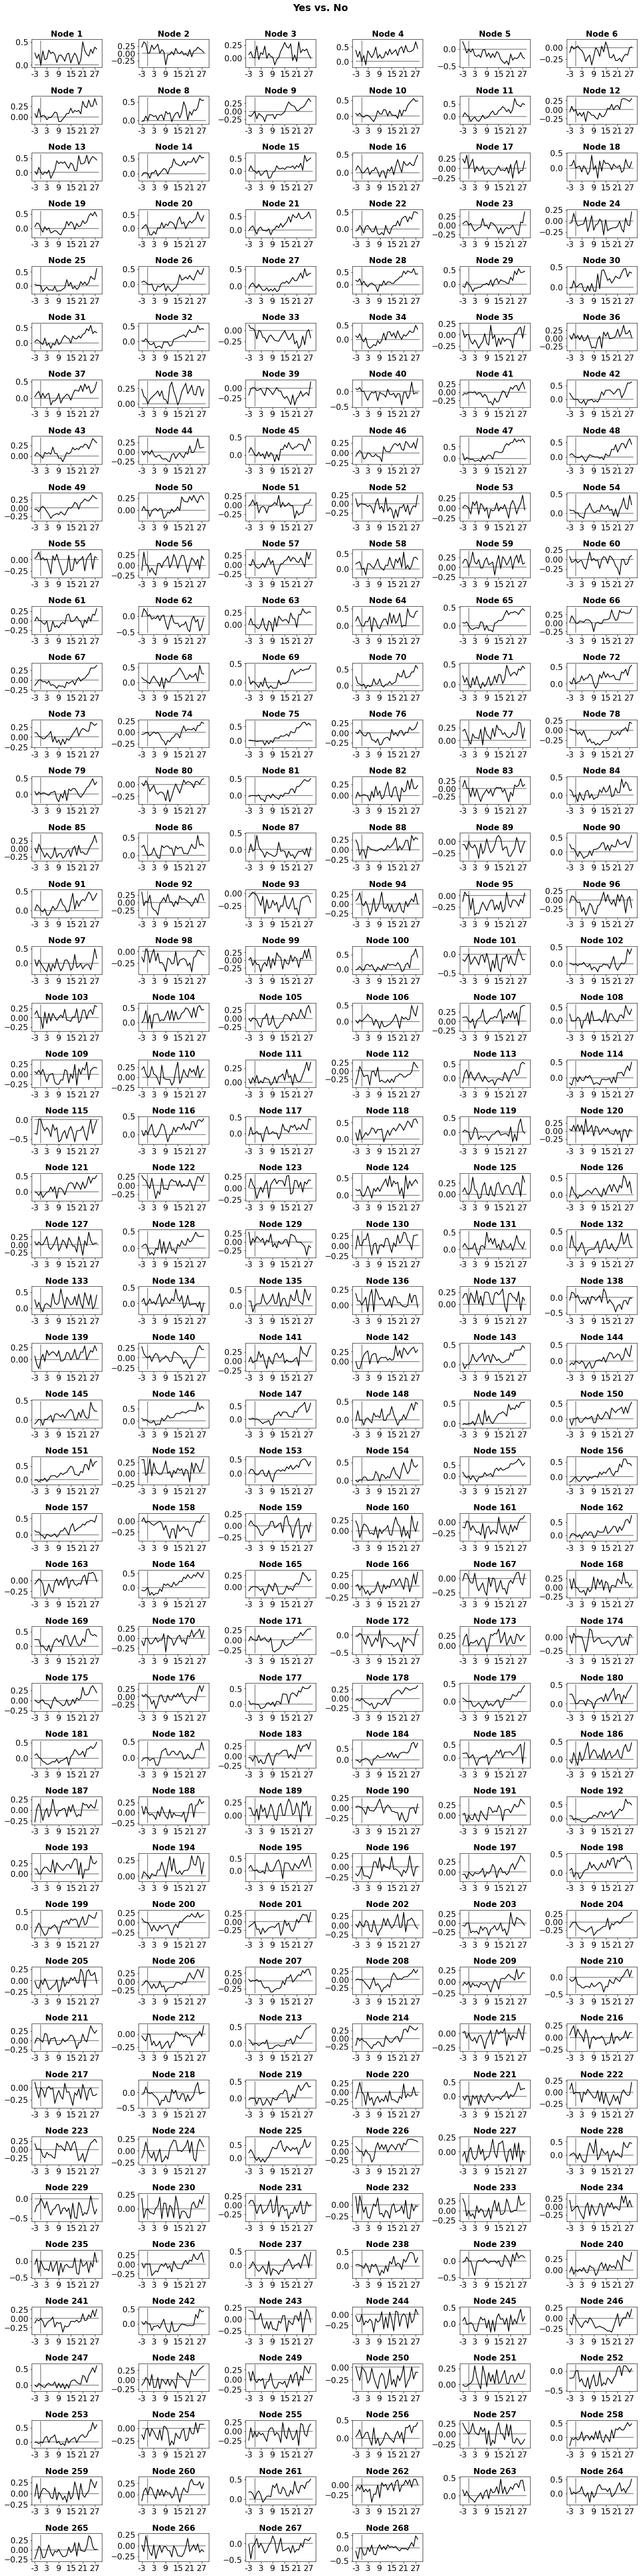

In [25]:
# social - nonsocial differences for each node
# same movie

if plot_fig == 1:
    ncols=6
    nrows = 45
    #nrows = int(np.ceil(len(sig_nodes)/ncols))

    xwidth = 18
    yheight = .55*nrows*xwidth/ncols
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = False, figsize = (xwidth,yheight))
    fig.set_figwidth(xwidth)
    fig.set_figheight(yheight)


nodes = np.arange(0,268)# np.arange(10)

for i_nodes,n in enumerate(nodes):
    if i_nodes % 50 ==0:
        print('node:',n)
    movieTC_yes = tcs_run_z[subs1,n,:,movie_ind_same] # nsubs * ntimepts
    movieTC_no = tcs_run_z[subs2,n,:,movie_ind_same] # nsubs * ntimepts

    if plot_fig:
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.title('Node '+ str(n+1),fontweight = 'bold')

    t_array = ttest_samemovies(movieTC_yes, movieTC_no, plot_fig, 'difference',0,tr0_ind) # values in [0,28]
    
if plot_fig:
    for i_nodes in np.arange(len(nodes),int(nrows*ncols)):
        plt.subplot(nrows,ncols,i_nodes+1)
        plt.axis('off')

    plt.suptitle('Yes vs. No',fontweight='bold')
    fig.tight_layout(rect=[0, 0.02, 1, 0.98])
    moviename = f'timecourses_Yes_vs_No_movie{movie_ind_same}_movie{movie_ind_same}.png'
    plt.savefig(os.path.join(data_file_loc,'figures',moviename))


